# Project I : 
## Association Rules in a Temporal Transactions Dataset

In [1]:
!pip install openpyxl  # uncomment if request by pandas .xlsx data loader
import openpyxl        # uncomment if request by pandas .xlsx data loader
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter
import scipy
from pandas.plotting import parallel_coordinates
import os
from pandas.plotting import scatter_matrix

if not os.path.exists('./Online_Retail.xlsx'):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx -O ./Online_Retail.xlsx

     |████████████████████████████████| 243 kB 3.6 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=37a1ff78dc3f3f985958cf160060d1cf903daab44ec1b6b40e09c99d75f34829
  Stored in directory: /tmp/pip-ephem-wheel-cache-2h5aoykh/wheels/6e/df/38/abda47b884e3e25f9f9b6430e5ce44c47670758a50c0c51759
Successfully built et-xmlfile


## Utils:

> **count_intervalset(sar, tt, d):**

The function has the goal to compute simultaneously *Count(X,Y,b1,D)* and check the presence of the interval sets *(X,b2,D)* and *(Y,b3,D)* wrt a temporal transaction, a slide association rule X->Y and a temporal-span D given as input parameters. The counting of (X,Y,b1,D) will consider only inteval sets which start with an item in X and where the first item of Y appears with a timestamp strictly grater than b1. 

**Input:**   
    - *sar:* temporal transaction rule X->Y in the form [ frozenset[X], frozenset[Y] ]        
    - *tt:* temporal transaction in the form [ [items_list], [timestamp_list] ]        
    - *d:* temporal-span     
    
**Output:**   
    - *count:* Count(X,Y,b1,D)   
    - *count_X:* 1 if tt feature (X,b1,d) for some b1 0 otherwise   
    - *count_Y:* 1 if tt feature (Y,b2,d) for some b2 0 otherwise   

In [2]:
def count_intervalset(sar, tt, d):
    
    count = 0
    count_X = 0
    count_Y = 0
    basetime = None
    
    # iterate through each item in tt
    for i in range(0,len(tt[0])): 
        
        present = []
        present_X = []
        present_Y = []
        absent = (list(sar[0])+list(sar[1]))[:]
        absent_X = list(sar[0])[:]
        absent_Y = list(sar[1])[:]
        
        # skip the iteration if the item is not part of the rule
        if(tt[0][i] in absent):
            
            # skip the iteration if the item has the same timestamp of the one checked previously
            if(basetime != None):
                if(basetime == tt[1][i]):    
                    continue
            basetime = tt[1][i]
            
            # iterate through each item whose timestamp are smaller than basetime+d 
            for idx in range(i,len(tt[0])):
                
                if(tt[1][idx] > basetime+d):
                    break
                
                # Y item check
                if((tt[1][idx] <= basetime+d and tt[0][idx] in absent_Y)):
                    present_Y.append(tt[0][idx])
                    absent_Y.remove(tt[0][idx])
                
                # X item check
                if((tt[1][idx] <= basetime+d and tt[0][idx] in absent_X)):
                    present_X.append(tt[0][idx])
                    absent_X.remove(tt[0][idx])
                    # ensure 'XUY item check' start with an element in the rule's antecedent
                    if (len(present) == 0 and tt[1][idx] == basetime):
                        present.append(tt[0][idx])
                        absent.remove(tt[0][idx])
                
                # XUY item check
                if((tt[1][idx] <= basetime+d and tt[0][idx] in absent) and len(present) != 0):
                    # keep the item in absent if it's part of the consequent and it has the same timestamp of the first items
                    if(tt[0][idx] in sar[1] and tt[1][idx] == basetime):
                        continue
                    # keep the item in absent if it's part of the antecedent and has timestamp equal to basetime+d        
                    if(tt[0][idx] in sar[0] and tt[1][idx] == basetime+d):
                        continue
                    present.append(tt[0][idx])
                    absent.remove(tt[0][idx])    
                        
        if(len(absent) == 0):
            count = count + 1
        if(len(absent_X) == 0):
            count_X = 1
        if(len(absent_Y) == 0):
            count_Y = 1

    
    return [count, count_X, count_Y]       


> **count_sar(sar, tt, d):**

This function compute and return *Count(X->Y,b,D)* wrt a temporal transaction tt and a temporal-span d.    

**Input:**   
    - *sar:* temporal transaction rule X->Y in the form [ frozenset[X], frozenset[Y] ]        
    - *tt:* temporal transaction in the form [ [items_list], [timestamp_list] ]        
    - *d:* temporal-span     
    
**Output:**   
    - *count:* Count(X->Y,b,D) 

In [3]:
def count_sar(sar, tt, d):
    
    count = 0
    basetime = None
    
    # iterate through each item in tt
    for i in range(0,len(tt[0])): 
        
        present_X = []
        present_Y = []
        absent_X = list(sar[0])[:]
        absent_Y = list(sar[1])[:]
        cuttime = None
        
        # skip the iteration if the item is not part of the antecedent of the rule  
        if(tt[0][i] in absent_X):
            
            # skip the iteration if the item has the same timestamp of the one checked previously
            if(basetime != None):
                if(basetime == tt[1][i]):    
                    continue            
            basetime = tt[1][i]
            
            # iterate through each item whose timestamp are smaller than basetime+d 
            for idx in range(i,len(tt[0])):
                
                if(len(absent_X) != 0):
                    # check item is in X and set the cuttime if all element in the antecedent of the rule have been finded
                    if((tt[1][idx] <= basetime+d and tt[0][idx] in absent_X)):
                        present_X.append(tt[0][idx])
                        absent_X.remove(tt[0][idx])    
                    if(len(absent_X) == 0):
                        cuttime = tt[1][idx]
                else:
                    # check item is in Y only if absent_X is empty and its timestamp is in a valid range
                    if(tt[0][idx] in absent_Y and tt[1][idx] > cuttime and tt[1][idx] <= basetime+d):
                        present_Y.append(tt[0][idx])
                        absent_Y.remove(tt[0][idx])
                
        
        if(len(absent_X) == 0 and len(absent_Y) == 0):
            count = count + 1
    
    return count


> **support_trans(sar, tt, d):**

This function return the transaction-level support of a slide association rule X->Y wrt a temporal transaction tt along with two integer which certify the presence of the interval set *(X,b2,D)* and *(Y,b3,D)* in the transaction.     

**Input:**   
    - *sar:* temporal transaction rule X->Y in the form [ frozenset[X], frozenset[Y] ]        
    - *tt:* temporal transaction in the form [ [items_list], [timestamp_list] ]        
    - *d:* temporal-span     
    
**Output:**   
    - *v:* transactional level support = num/den  
    - *v_X:* 1 if tt feature (X,b1,d) for some b1 0 otherwise   
    - *v_Y:* 1 if tt feature (Y,b2,d) for some b2 0 otherwise   

In [4]:
def support_trans(sar, tt, d):
    
    num = count_sar(sar, tt, d)
    den, v_X, v_Y = count_intervalset(sar, tt, d)
    
    if (den > 0):
        v = num/den
    else:
        v = 0
        
    return [v, v_X, v_Y]
    

> **support_sar(sar, tdt, d, tsi, epsilon):**

This function return the transaction-level support of a slide association rule X->Y wrt a temporal transaction dataset tdt along with two integer which represent the support of the antecedent and consequent of the rule. For each transaction is computed the transaction_level support: the contribution that this value will give to the whole support is defined by the temporal support indicator *tsi* and, in case tsi='value', the threshold value epsilon.       

**Input:**   
    - *sar:* temporal transaction rule X->Y in the form [ frozenset[X], frozenset[Y] ]        
    - *tdt:* temporal transaction dataset in the form [[ [items_list], [timestamp_list] ]...]        
    - *d:* temporal-span     
    - *tsi:* one of the following temporal suport indicator: {'value', 'universal', 'existential', 'epsilon'}.    
    - *epsilon:* threshold value to take into consideration if tsi='value'     
    
**Output:**   
    - *supp:* temporal support wrt the rule X->Y and the time-span D   
    - *supp_X:* temporal support of the set X on a time-span D    
    - *supp_Y:* temporal support of the set Y on a time-span D   

In [5]:
def support_sar(sar, tdt, d, tsi, epsilon):
    
    count = 0
    count_X = 0
    count_Y = 0
    
    for tt in tdt:
        v, v_X, v_Y = support_trans(sar, tt, d)
        count_X = count_X + v_X
        count_Y = count_Y + v_Y
        if(tsi == "value"):
            count = count + v 
        else:           
            if(tsi == "universal" and v != 1 ):
                continue;
            if(tsi == "existential" and v == 0):
                continue;
            if(tsi == "epsilon" and v < epsilon):
                continue;
            count = count + 1
        
    supp = float(count)/len(tdt)
    supp_X = float(count_X)/len(tdt)
    supp_Y = float(count_Y)/len(tdt)

    return [supp, supp_X, supp_Y]


> **find_sars(tdt, rules, d, ts, tsi, epsilon):**

The goal of this function is to filter a list of slide association rules keeping only the ones with temporal support greater or equal to the threshold value ts. The function computes the support of the antecedent and consequent of the rule and return these value along with the support of the rules and the rules themself.         

**Input:**   
    - *tdt:* temporal transaction dataset in the form [[ [items_list], [timestamp_list] ]...]           
    - *rules:* list of slide association rules in the form [[ frozenset[X], frozenset[Y] ]...]         
    - *d:* temporal-span  
    - *ts:* temporal support threshold  
    - *tsi:* one of the following temporal suport indicator: {'value', 'universal', 'existential', 'epsilon'}    
    - *epsilon:* threshold value to take into consideration if tsi='value'     
    
**Output:**   
    - *sars:* list of slide association rules in the form [[ frozenset[X], frozenset[Y], supp_rule, supp_X, supp_Y]...]  

In [6]:
def find_sars(tdt, rules, d, ts, tsi, epsilon):
    
    sars = []
    
    for r in rules:
        supp_s, supp_X, supp_Y = support_sar(r, tdt, d, tsi, epsilon)
        if(supp_s >= ts):
            tmp = []
            tmp.append(r[0])
            tmp.append(r[1])
            tmp.append(supp_s)
            tmp.append(supp_X)
            tmp.append(supp_Y)
            sars.append(tmp)
            
    return sars
    

> **filter_sars(sars, tmn, tv):**

The goal of this function is to filter a list of slide association rules keeping only the ones with 'metric' greater or equal to the threshold value tv. The metric to use as reference is the one whose name is contained in tmn.         

**Input:**   
    - *sars:* list of slide association rules in the form [[ frozenset[X], frozenset[Y], supp_rule, supp_X, supp_Y]...]             
    - *tmn:* a metric name from the following set: {'confidence', 'lift', 'completeness'}            
    - *tv:* metric threshold value     
    
**Output:**   
    - *f_sars:* the filtered list of slide association rules in the form [[ frozenset[X], frozenset[Y], supp_rule, supp_X, supp_Y]...] 

In [7]:
def filter_sars(sars, tmn, tv):
    
    f_sars = []
    
    for sar in sars:
        if(tmn == "confidence" and tv <= sar[2]/sar[3]):
            f_sars.append(sar)
            
        if(tmn == "lift" and tv <= sar[2]/(sar[3]*sar[4])):
            f_sars.append(sar)
    
        if(tmn == "completeness" and tv <= sar[2]/sar[4]):
            f_sars.append(sar)
    
    return f_sars


> **extract_sars(tdt, ...):**

The goal of this function is to generate the association rules (standard and slide) wrt the temporal transactional dataset tdt (with attributes 'Transaction_ID', 'Item_Label', and 'TimeStamp') and the other function's parameters.   
*!WARNING!: there's NOT a control phase to check that the parameters are in range/valid!*  
*!WARNING!: currently there is NOT an implementation of the static association rules extractor which use 'completeness' as filter metric!*

**Input:**  
    - *tdt:* pandas DataFrame representing the temporal transactional dataset      
    - *static_support = 0.05:* static support threshold value     
    - *static_metric_name = 'confidence':* reference metric for the static rules pruning, one in {'confidence', 'lift', 'completeness'}     
    - *static_metric_value = 0.8:* static metric threshold value  
    - *duration = 100:* time-span  
    - *temporal_support_indicator = 'value':* reference count-function related to the temporal support, one in {'value', 'universal', 'existential', 'epsilon'}    
    - *indicator_epsilon_value = 0.2:* epsilon threshold value   
    - *temporal_support = 0.02:* temporal support threshold value   
    - *temporal_metric_name = 'confidence':* reference metric for the temporal rules pruning, one in {'confidence', 'lift', 'completeness'}        
    - *temporal_metric_value = 0.3:* temporal metric threshold value   

**Output:**    
    - ar: a list of 2 element: the first is the pandas DataFrame of the standard association rules, the second is the DataFrame of the slide association rules.

In [8]:
def extract_sars(tdt,
                static_support = 0.05, 
                static_metric_name = 'confidence', 
                static_metric_value = 0.8, 
                duration = 100, 
                temporal_support_indicator = 'value', 
                indicator_epsilon_value = 0.2,
                temporal_support = 0.02,
                temporal_metric_name = 'confidence',
                temporal_metric_value = 0.3):
    
    ar = []
    
    transactions_ = tdt.groupby(['Transaction_ID'])['Item_Label'].apply(list).values.tolist()
    te = TransactionEncoder()
    onehot = te.fit(transactions_).transform(transactions_)
    onehot.astype("int")
    dft = pd.DataFrame(onehot, columns=te.columns_)
    
    frequent_itemsets = apriori(dft, min_support = static_support, use_colnames = True)    
    
    # dataframe refactor if 'completeness' is chosen as metric (swap antecedents & consequents)
    if static_metric_name == 'completeness':
        ar.append(association_rules(frequent_itemsets, metric = 'confidence', min_threshold = static_metric_value))
        tmp = ar[0]['antecedents'].values.tolist()
        ar[0]['antecedents'] = ar[0]['consequents']
        ar[0]['consequents'] = tmp
        tmp = ar[0]['antecedent support'].values.tolist()
        ar[0]['antecedent support'] = ar[0]['consequent support']
        ar[0]['consequent support'] = tmp
        ar[0].rename(columns = {'confidence':'completeness'}, inplace = True)
        ar[0]['conviction'] = ar[0].apply(lambda x: (x['antecedent support']*(1-x['consequent support']))/(x['antecedent support']-x['support']), axis = 1)
    else:
        ar.append(association_rules(frequent_itemsets, metric = static_metric_name, min_threshold = static_metric_value))
        
    rules = ar[0].loc[:,["antecedents","consequents"]].values.tolist()
    print("Step 1 Ended: rules finded --> ", len(rules))
    print("\n")
    
    transactions = tdt.sort_values(by='TimeStamp').groupby(['Transaction_ID']).agg(lambda x: list(x)).values.tolist()
    sars = find_sars(transactions, rules, duration, temporal_support,  temporal_support_indicator, indicator_epsilon_value)
    print("Step 2 Ended: temporal rules finded --> ", len(sars))
    print("\n")
    sars = filter_sars(sars, temporal_metric_name, temporal_metric_value)
    ar.append(pd.DataFrame(sars, columns=['antecedents','consequents','support', 'supp_ant', 'supp_cons']))
    print("Step 3 Ended: temporal rules remaining --> ", len(ar[1]))
    print("\n")
    return ar


> **date_to_days(date):**

This function transform a DateTime object in an integer representing the number of day passed since 1/1/0000.         

**Input:**   
    - *date:* DateTime object    
    
**Output:**   
    - *x:* number of day since 1/1/0000 

In [9]:
def date_to_days(date):
    
    months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    x = 0
    bis = date.year % 4 == 0 and (date.year % 100 != 0 or date.year % 400 == 0)
    
    for i in range(0, date.year-1):
        x = x + 365
        if (i % 4 == 0 and (i % 100 != 0 or i % 400 == 0)):
            x = x + 1
    
    for i in range(0, date.month-1):
        x = x + months[i] 
    
    if(date.month > 2 and bis):
        x = x + 1
    x = x + date.day 
    
    return x 


## Dataset Loading and Preprocessing:

In this phase we load the dataset as pandas DataFrame. The name of the main 3 attributes are changed to match the name detected by the function.   
For the same reason the function *date_to_days* is applied to the ex-InvoiceDate column to transform the DateTime values in numerical values.

In [10]:
df = pd.read_excel("Online_Retail.xlsx")

In [11]:
df = df.rename(columns = {"CustomerID":"Transaction_ID","Description":"Item_Label","InvoiceDate":"TimeStamp"})
filtdf = df.loc[:,["Transaction_ID","Item_Label","TimeStamp"]]
filtdf['TimeStamp'] = filtdf['TimeStamp'].apply(date_to_days)

## Rules extraction:

The rules extraction has been made according to 3 different scenarios characterized by their different parameters:

- sc1: 
    - *default parameters*.

  
- sc2:     
    - *static_support = 0.05*    
    - *static_metric_name = 'lift'*      
    - *static_metric_value = 10* 
    - *duration = 100*
    - *temporal_support_indicator = 'epsilon'* 
    - *indicator_epsilon_value = 0.49*    
    - *temporal_support = 0.02*    
    - *temporal_metric_name = 'lift'* 
    - *temporal_metric_value = 4* 

  
- sc3:
    - *static_support = 0.05*    
    - *static_metric_name = 'confidence'*      
    - *static_metric_value = 0.8* 
    - *duration = 100*
    - *temporal_support_indicator = 'existential'*     
    - *temporal_support = 0.02*    
    - *temporal_metric_name = 'completeness'* 
    - *temporal_metric_value = 0.3*

In [12]:
sc1 = extract_sars(filtdf)
sc1[1]['confidence'] = sc1[1].apply(lambda x: x['support']/x['supp_ant'], axis=1)
sc1[1]['completeness'] = sc1[1].apply(lambda x: x['support']/x['supp_cons'], axis=1)
sc1[1]['lift'] = sc1[1].apply(lambda x: x['support']/(x['supp_ant'] * x['supp_cons']), axis=1)
sc1[1]['jmeasure'] = sc1[1].apply(lambda x: 
                                  (x['supp_ant'] * (x['confidence']*np.log2(x['confidence']/x['supp_cons'])+(1-x['confidence'])*np.log2((1-x['confidence'])/(1-x['supp_cons'])))), 
                                  axis=1)
sc1[1]

Step 1 Ended: rules finded -->  26


Step 2 Ended: temporal rules finded -->  9


Step 3 Ended: temporal rules remaining -->  5




,antecedents,consequents,support,supp_ant,supp_cons,confidence,completeness,lift,jmeasure
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.031336,0.073879,0.089433,0.424149,0.350384,4.742654,0.042246
1,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.026761,0.089204,0.097667,0.300000,0.274005,3.071663,0.020454
2,(PINK REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.024245,0.073422,0.202882,0.330218,0.119504,1.627636,0.004691
3,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.028820,0.088060,0.196249,0.327273,0.146853,1.667641,0.006055
4,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(REGENCY CAKESTAND 3 TIER),0.020152,0.067017,0.202882,0.300702,0.099330,1.482150,0.002588


In [19]:
sc2 = extract_sars(filtdf,
                static_support = 0.05, 
                static_metric_name = 'lift', 
                static_metric_value = 10, 
                duration = 100, 
                temporal_support_indicator = 'epsilon', 
                indicator_epsilon_value = 0.49,
                temporal_support = 0.02,
                temporal_metric_name = 'lift',
                temporal_metric_value = 4)
sc2[1]['confidence'] = sc2[1].apply(lambda x: x['support']/x['supp_ant'], axis=1)
sc2[1]['completeness'] = sc2[1].apply(lambda x: x['support']/x['supp_cons'], axis=1)
sc2[1]['lift'] = sc2[1].apply(lambda x: x['support']/(x['supp_ant'] * x['supp_cons']), axis=1)
sc2[1]['jmeasure'] = sc2[1].apply(lambda x: 
                                  (x['supp_ant'] * (x['confidence']*np.log2(x['confidence']/x['supp_cons'])+(1-x['confidence'])*np.log2((1-x['confidence'])/(1-x['supp_cons'])))), 
                                  axis=1)
sc2[1]

Step 1 Ended: rules finded -->  22


Step 2 Ended: temporal rules finded -->  5


Step 3 Ended: temporal rules remaining -->  1




,antecedents,consequents,support,supp_ant,supp_cons,confidence,completeness,lift,jmeasure
0,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.020357,0.065874,0.073651,0.309028,0.276398,4.195868,0.022867


In [20]:
sc3 = extract_sars(filtdf,
                static_support = 0.05, 
                static_metric_name = 'confidence', 
                static_metric_value = 0.8, 
                duration = 100, 
                temporal_support_indicator = 'existential',
                temporal_support = 0.02,
                temporal_metric_name = 'completeness',
                temporal_metric_value = 0.3)
sc3[1]['confidence'] = sc3[1].apply(lambda x: x['support']/x['supp_ant'], axis=1)
sc3[1]['completeness'] = sc3[1].apply(lambda x: x['support']/x['supp_cons'], axis=1)
sc3[1]['lift'] = sc3[1].apply(lambda x: x['support']/(x['supp_ant'] * x['supp_cons']), axis=1)
sc3[1]['jmeasure'] = sc3[1].apply(lambda x: 
                                  (x['supp_ant'] * (x['confidence']*np.log2(x['confidence']/x['supp_cons'])+(1-x['confidence'])*np.log2((1-x['confidence'])/(1-x['supp_cons'])))), 
                                  axis=1)
sc3[1]

Step 1 Ended: rules finded -->  26


Step 2 Ended: temporal rules finded -->  12


Step 3 Ended: temporal rules remaining -->  1




,antecedents,consequents,support,supp_ant,supp_cons,confidence,completeness,lift,jmeasure
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.031336,0.073879,0.089433,0.424149,0.350384,4.742654,0.042246


##  Results and Visualization:

What follow are the hit-map and the scatter-matrix related to the first scenario *sc1*.

The most meaningfull in this scenario is:
- _ALARM CLOCK BAKELIKE GREEN  **-->**  ALARM CLOCK BAKELIKE RED_ 

This rule, in the analyzed context, has the gretest values for each metrics in particolar for the lift value.
Even the J-measure, although is quite low in absolute term, is significantly greater wrt the ones of the other rules.

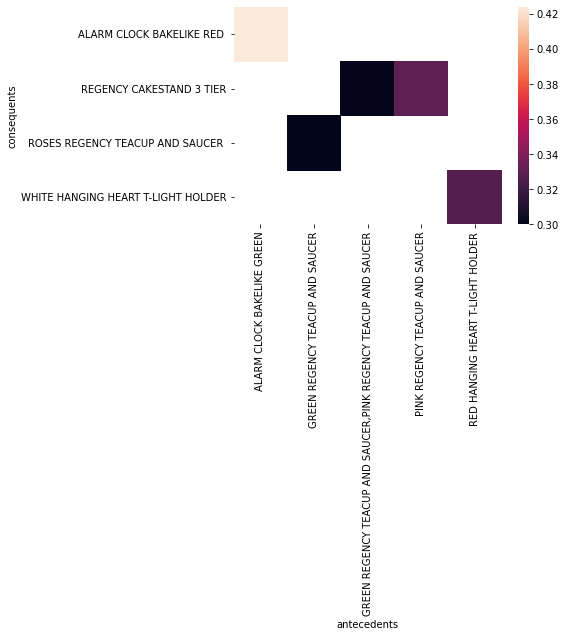

In [21]:
sc1[1]['antecedents'] = sc1[1]['antecedents'].apply(lambda a: ','.join(list(a))) 
sc1[1]['consequents'] = sc1[1]['consequents'].apply(lambda a: ','.join(list(a)))
st1 = sc1[1].pivot(index='consequents', columns='antecedents', values='confidence')
hm1 = sns.heatmap(st1)

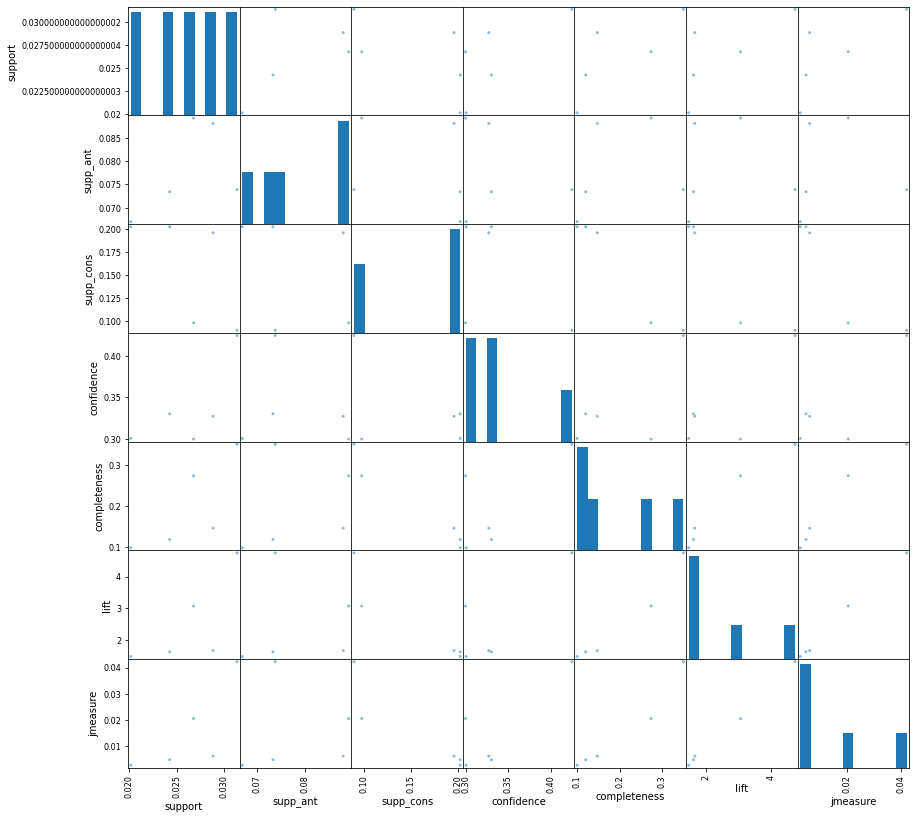

In [23]:
scatter_matrix(sc1[1].replace([np.inf, -np.inf], np.nan).dropna(), figsize=(14, 14));